In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Conv2D, concatenate, Activation, MaxPooling2D, UpSampling2D, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
import matplotlib.pyplot as plt
import random
import os

In [5]:

images_path = ['dataA/CameraRGB' ]
masks_path = ['dataA/CameraSeg' ]

In [6]:
def return_paths(path):
    X = []
    for i in sorted(path):
        g = sorted(os.listdir(i))
        for j in g:
            X.append(i + '/' + j)
    return X

In [7]:
X = return_paths(images_path)
Y = return_paths(masks_path)


In [8]:
print(len(X))
print(len(Y))

1000
1000


In [9]:
# Splitting the data into train, validation and test sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2)
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size = 0.2)

In [10]:
def read_imageMask(image_path, mask_path):
    
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (256, 256), method='nearest')
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, (256, 256), method='nearest')
    
    return img, mask

In [11]:
def data_generator(image_paths, mask_paths, batch_size):
    images = tf.constant(image_paths)
    masks = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.map(read_imageMask, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.cache().shuffle(500).batch(batch_size)
    
    return dataset

In [13]:
train_generator = data_generator(X_train, Y_train, 32)
val_generator = data_generator(X_val, Y_val, 32)
test_generator = data_generator(X_test, Y_test, 32)

In [14]:
def unet(num_classes = 13, image_shape = (256, 256, 3)):
    # Input
    inputs = Input(image_shape)
    # Encoder Path
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2,2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D((2,2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D((2,2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D((2,2))(drop4)
    
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Decoder Path
    up6 = Conv2D(512, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(drop5))
    merge6 = concatenate([up6, conv4], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv6))
    merge7 = concatenate([up7, conv3], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([up8, conv2], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([up9, conv1], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    
    conv10 = Conv2D(num_classes, (1, 1), padding='same', activation='softmax')(conv9)
    
    model = Model(inputs, conv10)
    
    return model

In [15]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 up_sampling2d_3 (UpSampling2D)  (None, 256, 256, 12  0          ['conv2d_18[0][0]']              
                                8)                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  32832       ['up_sampling2d_3[0][0]']        
                                )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 256, 256, 12  0           ['conv2d_19[0][0]',              
                                8)                                'conv2d_1[0][0]']               
                                                                                                  
 conv2d_20

In [16]:
# Complile The Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the Callbacks we will use during training
earlystopping = EarlyStopping(monitor='val_loss', patience= 20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)

In [17]:
# Train the Model
history = model.fit(train_generator, validation_data=val_generator,epochs=18,
                    verbose = 1, batch_size=16,
                    callbacks=[earlystopping, reduce_lr])

Epoch 1/18


2023-01-05 14:08:27.160259: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1073741824 exceeds 10% of free system memory.
2023-01-05 14:08:27.401968: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1073741824 exceeds 10% of free system memory.
2023-01-05 14:08:30.638684: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1073741824 exceeds 10% of free system memory.
2023-01-05 14:08:33.998581: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1073741824 exceeds 10% of free system memory.


 1/25 [>.............................] - ETA: 11:33 - loss: 2.6845 - accuracy: 0.0645

2023-01-05 14:08:53.083523: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1073741824 exceeds 10% of free system memory.


25/25 [==============================] - 656s 26s/step - loss: 62.3377 - accuracy: 0.3456 - val_loss: 1.8074 - val_accuracy: 0.3562 - lr: 0.0010
Epoch 2/18
25/25 [==============================] - 640s 26s/step - loss: 1.5414 - accuracy: 0.4848 - val_loss: 1.3102 - val_accuracy: 0.5640 - lr: 0.0010
Epoch 3/18
25/25 [==============================] - 622s 25s/step - loss: 1.3470 - accuracy: 0.5415 - val_loss: 1.2871 - val_accuracy: 0.5946 - lr: 0.0010
Epoch 4/18
25/25 [==============================] - 635s 25s/step - loss: 1.0725 - accuracy: 0.6631 - val_loss: 0.9453 - val_accuracy: 0.7104 - lr: 0.0010
Epoch 5/18
25/25 [==============================] - 637s 25s/step - loss: 0.8045 - accuracy: 0.7451 - val_loss: 0.7286 - val_accuracy: 0.7630 - lr: 0.0010
Epoch 6/18
25/25 [==============================] - 610s 24s/step - loss: 0.6310 - accuracy: 0.7965 - val_loss: 0.5672 - val_accuracy: 0.8142 - lr: 0.0010
Epoch 7/18
25/25 [==============================] - 611s 24s/step - loss: 0.5194

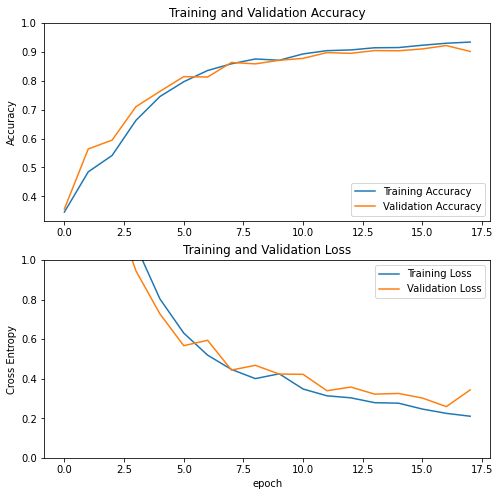

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
train_loss, train_accuracy = model.evaluate(train_generator, batch_size = 32)
validation_loss, validation_accuracy = model.evaluate(val_generator, batch_size = 32)
test_loss, test_accuracy = model.evaluate(test_generator, batch_size = 32)

2/2 [==============================] - 6s 1s/step - loss: 0.3288 - accuracy: 0.9087


1/1 [==============================] - 1s 1s/step


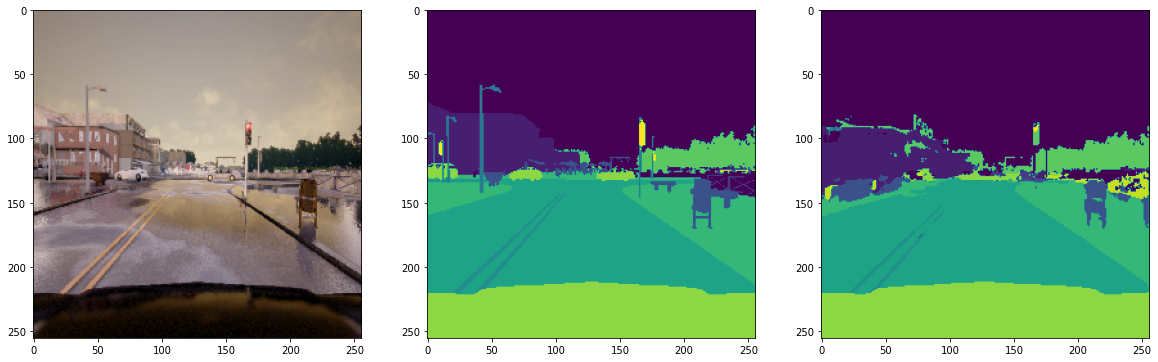

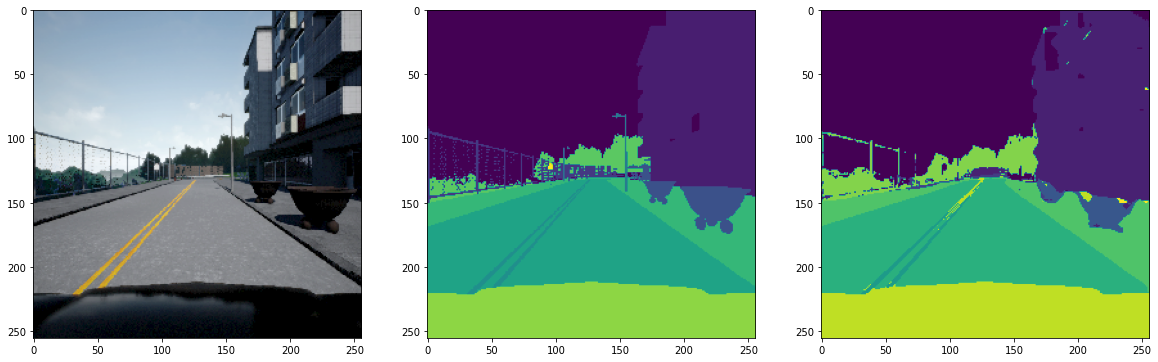

In [20]:
for image, mask in test_generator.take(6):
    pred_mask = model.predict(image)
    
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image[0]))
    plt.subplot(1, 3, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[0]))
    plt.subplot(1, 3, 3)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(tf.expand_dims(tf.argmax(pred_mask[0], axis = -1), axis = -1)))